In [ ]:
import pandas as pd
import itertools
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import numpy as np
import os
import shap
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

from scipy.stats import mannwhitneyu
from scipy.stats import uniform, randint
from sklearn import preprocessing
from sklearn.model_selection import ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score, accuracy_score
import tqdm as notebook_tqdm
import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBClassifier 



c:\Users\odiee\anaconda3\envs\hcml2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Subsampling Data

In [ ]:
df = pd.read_csv("ACSPUMS1.csv")

In [ ]:
print(df.head())
df.isna().sum()

   PWGTP  RAC1P  SEX  MAR  HICOV  DIS NAICSP  NATIVITY  ENG  SCHL  AGEP  \
0     13      1    1    1      2    2     23         1    0    17    35   
1     17      2    1    5      2    2      N         1    0    12    43   
2      6      2    2    5      1    1   4853         1    0    18    58   
3     12      1    1    5      2    2      N         1    0    12    25   
4     14      1    1    5      1    2  611M1         1    0    16    21   

   PINCP  WKHP  Unnamed: 13  
0  63000    80          NaN  
1      0     0          NaN  
2  23100    20          NaN  
3      0     0          NaN  
4  17000    40          NaN  


PWGTP                 0
RAC1P                 0
SEX                   0
MAR                   0
HICOV                 0
DIS                   0
NAICSP                0
NATIVITY              0
ENG                   0
SCHL                  0
AGEP                  0
PINCP                 0
WKHP                  0
Unnamed: 13    15912393
dtype: int64

In [ ]:
print("NAICSP dtype:", df['NAICSP'].dtype)
print("Unique values (sample):", df['NAICSP'].unique()[:10])

NAICSP dtype: object
Unique values (sample): ['23' 'N' '4853' '611M1' '562' '722Z' '6216' '4551' '721M' '5617Z']


In [ ]:
# filter out NaN column
df = df.drop(columns=['Unnamed: 13', 'PWGTP', 'ENG', 'NATIVITY'], errors='ignore')

# preprocess NAICS
df = df[df['NAICSP'] !='N']
df = df[df['NAICSP'] !='999920']

In [ ]:
# Check for '999920' as a string
print("'999920' in NAICSP?", '999920' in df['NAICSP'].astype(str).values)

# Check for 999920 as an integer
print("999920 in NAICSP?", 999920 in df['NAICSP'].values)

print("'N' in NAICSP?", 'N' in df['NAICSP'].astype(str).values)

'999920' in NAICSP? False
999920 in NAICSP? False
'N' in NAICSP? False


### Pre-processing - regrouping data

In [ ]:
raw_data = df.copy()

# Categorize AGEP into bins
age_bins = [18, 25, 45, 60, float('inf')]
age_labels = ['18_25','25_45', '45_60', '60_plus']
raw_data['AGEP'] = pd.cut(raw_data['AGEP'], bins=age_bins, labels=age_labels, right=False)
raw_data = raw_data.dropna(subset=['AGEP'])
# Binarize MAR
raw_data['MAR'] = raw_data['MAR'].apply(lambda x: 1 if x == 1 else 0)

# Filter by RAC1P values
valid_rac1p_values = [1, 2, 6, 8, 9]
raw_data = raw_data[raw_data['RAC1P'].isin(valid_rac1p_values)]


In [ ]:
raw_data.head()

,RAC1P,SEX,MAR,HICOV,DIS,NAICSP,NATIVITY,ENG,SCHL,AGEP,PINCP,WKHP
0,1,1,1,2,2,23,1,0,17,25_45,63000,80
2,2,2,0,1,1,4853,1,0,18,45_60,23100,20
4,1,1,0,1,2,611M1,1,0,16,18_25,17000,40
5,1,1,0,2,2,562,1,0,12,45_60,7700,50
6,6,2,0,1,2,611M1,2,0,19,18_25,2000,15


### Pre-processing: subsampling data

In [ ]:
raw_data['strata'] = raw_data[['DIS','RAC1P','SEX', 'AGEP', 'MAR']].astype(str).agg('_'.join, axis=1)

sample,_ = train_test_split(raw_data, 
                             train_size=500000, 
                             stratify=raw_data['strata'], 
                             random_state=42)

### Check for proportions

In [ ]:
print(raw_data['DIS'].value_counts(normalize=True))
print(sample['DIS'].value_counts(normalize=True)) 

print(raw_data['SEX'].value_counts(normalize=True))
print(sample['SEX'].value_counts(normalize=True))

DIS
2    0.902864
1    0.097136
Name: proportion, dtype: float64
DIS
2    0.902866
1    0.097134
Name: proportion, dtype: float64
SEX
1    0.513725
2    0.486275
Name: proportion, dtype: float64
SEX
1    0.513724
2    0.486276
Name: proportion, dtype: float64


In [ ]:
print(raw_data['RAC1P'].value_counts(normalize=True))
print(sample['RAC1P'].value_counts(normalize=True))

RAC1P
1    0.710612
2    0.086609
9    0.085958
6    0.064260
8    0.052561
Name: proportion, dtype: float64
RAC1P
1    0.710612
2    0.086610
9    0.085956
6    0.064260
8    0.052562
Name: proportion, dtype: float64


In [ ]:
print(raw_data['AGEP'].value_counts(normalize=True))
print(sample['AGEP'].value_counts(normalize=True))

AGEP
25_45      0.369033
45_60      0.279616
60_plus    0.231918
18_25      0.119433
Name: proportion, dtype: float64
AGEP
25_45      0.369032
45_60      0.279622
60_plus    0.231916
18_25      0.119430
Name: proportion, dtype: float64


In [ ]:
sample.drop('strata', axis=1, inplace=True)
print(sample.head())

          RAC1P  SEX  MAR  HICOV  DIS NAICSP  SCHL     AGEP   PINCP  WKHP
10214554      1    2    1      1    2   6111    21    45_60   36000    45
2743816       1    1    1      1    2   6212    23  60_plus  115000    18
8875463       1    1    1      1    2    712    22    25_45   67000    40
1615968       2    2    0      1    2   5416    16    18_25    1200    25
14294123      1    2    1      1    2   4491    18    25_45   34000    40


In [ ]:
# save sample locally
sample.to_csv("sample_data.csv", index=False)

## Load sample

In [2]:
sample = pd.read_csv("sample_data.csv")

In [3]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP','DIS','NAICSP','SCHL', 'MAR', 'SEX',  'RAC1P']

In [ ]:
insurance_data = sample.copy() 
income_data = sample.copy()

In [5]:
insurance_data.rename(columns={"HICOV": "target"}, inplace=True)

In [6]:
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

## Data analysis/visualization

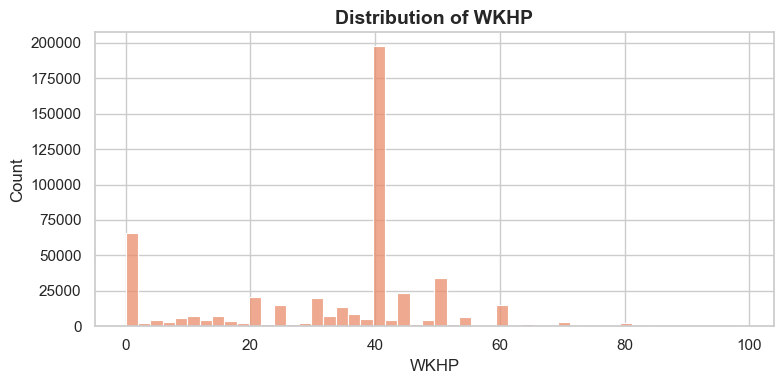

In [ ]:
sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(insurance_data[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


### Categorical value visualization

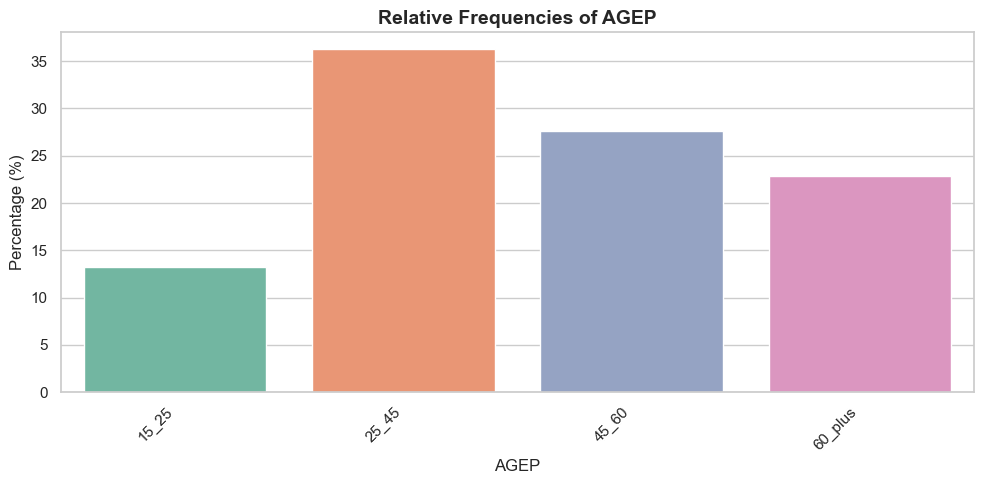

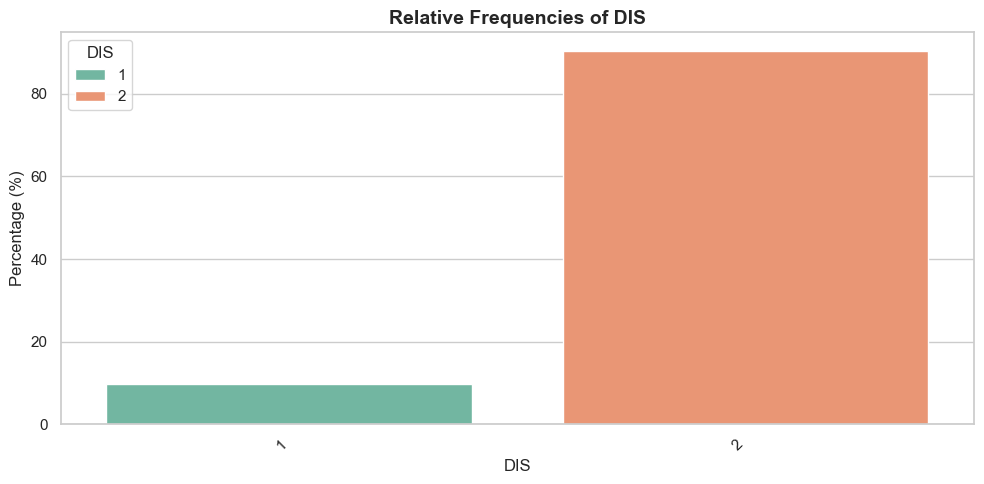

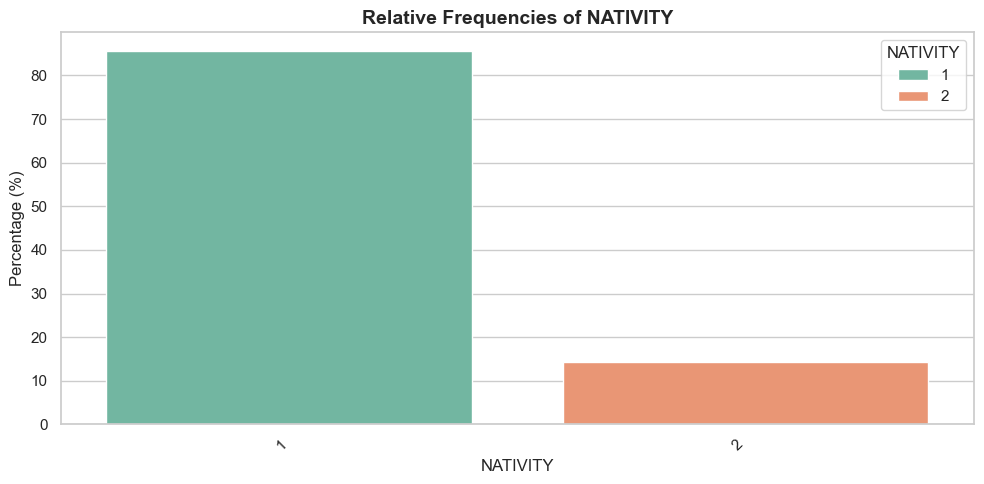

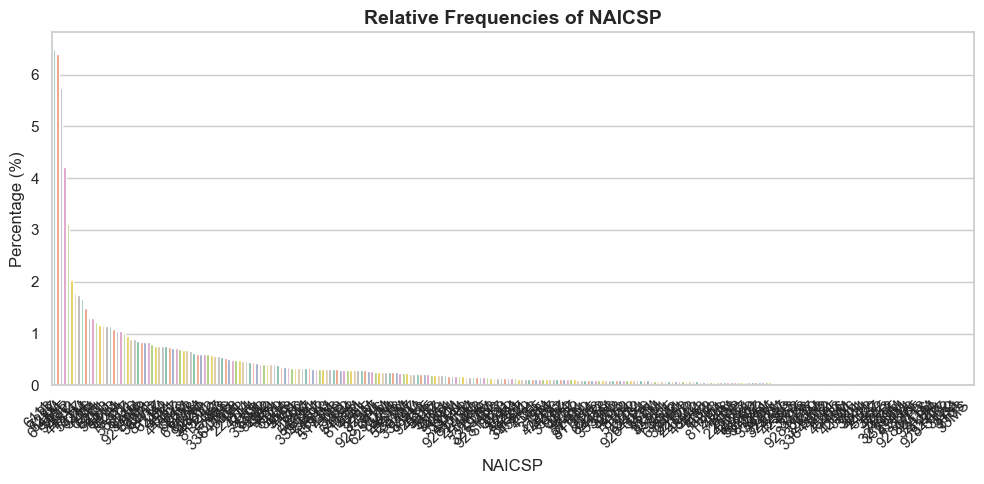

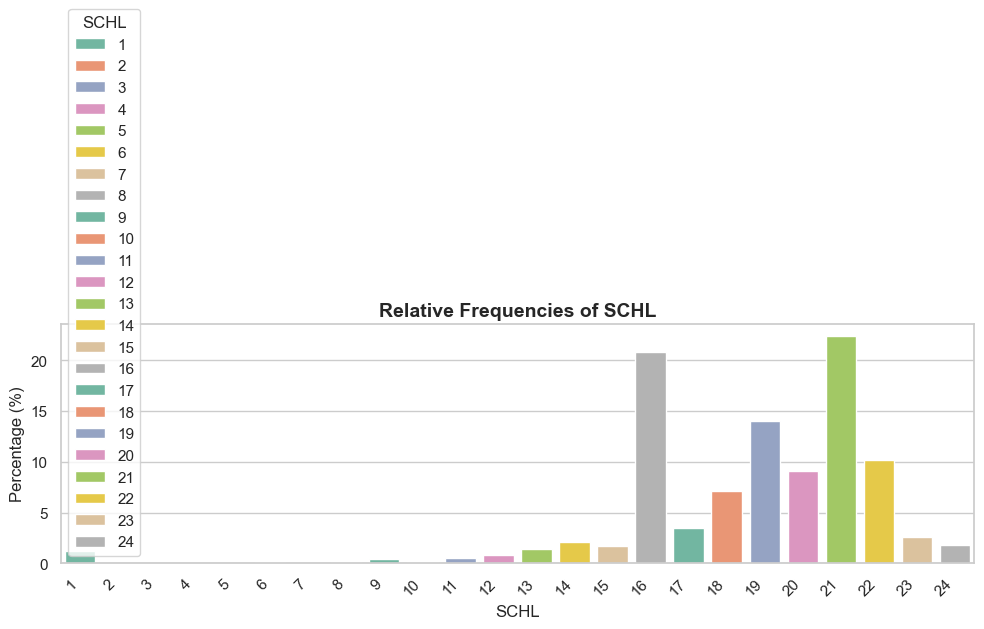

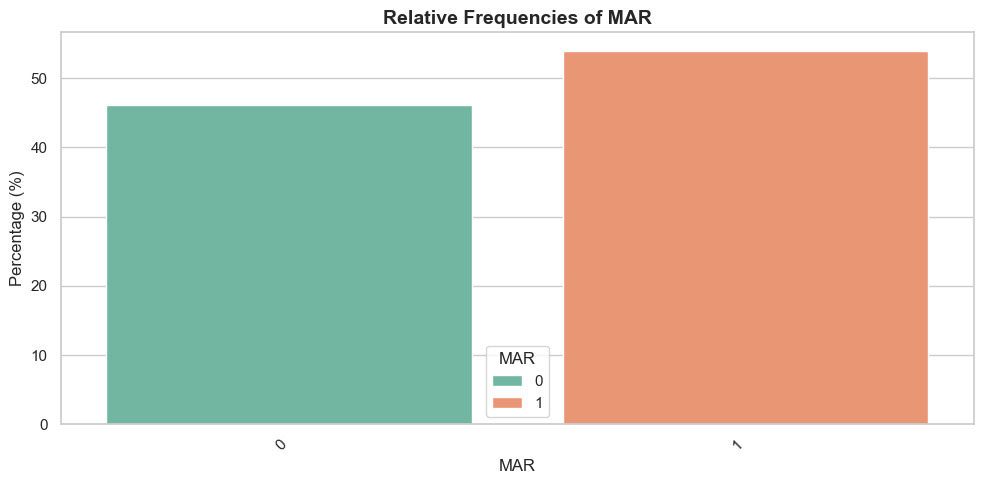

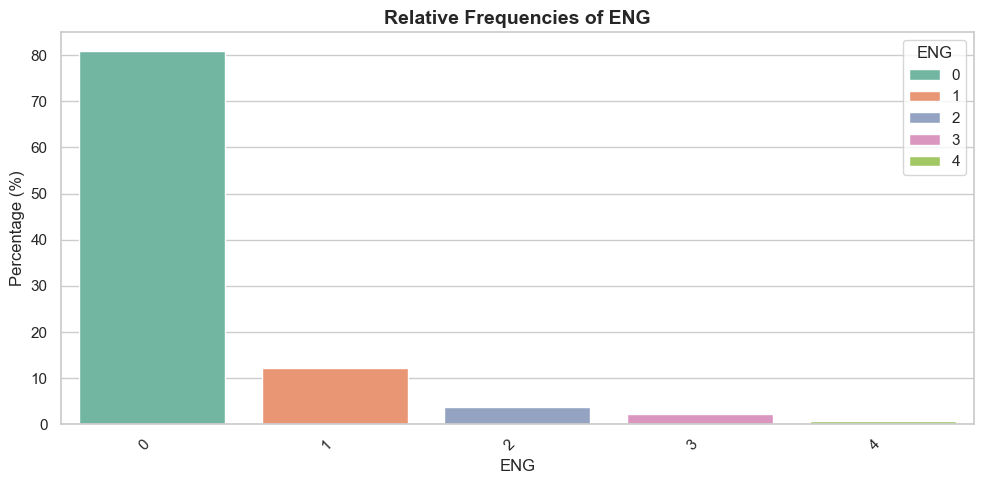

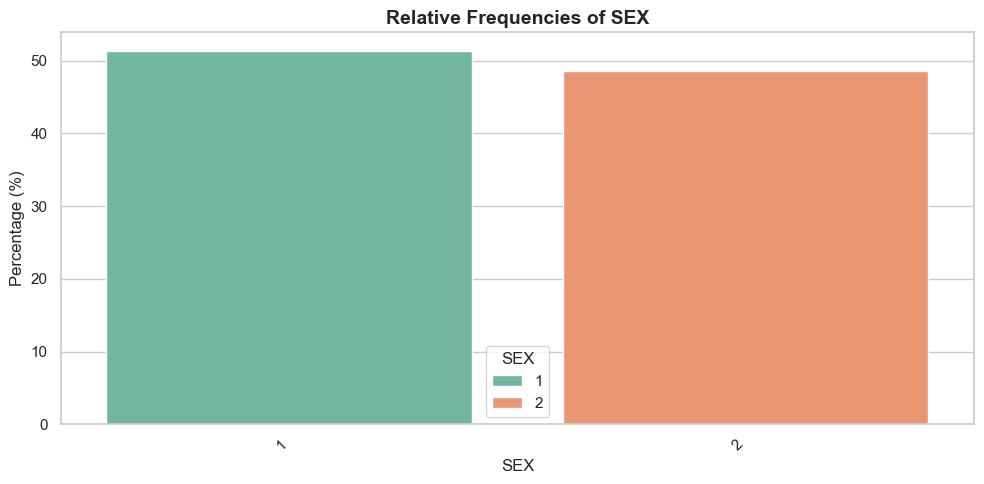

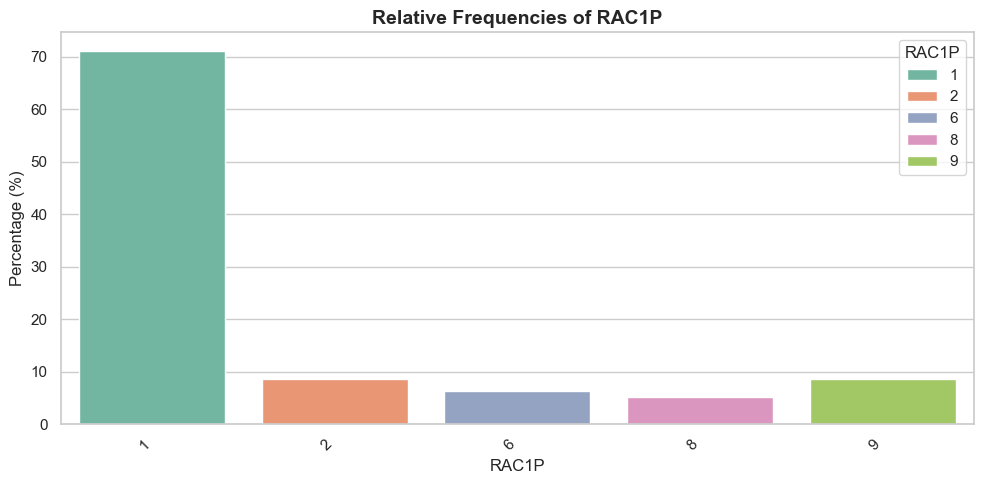

In [ ]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = insurance_data[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Creating thresholds, splitting datasets and encoding data

### Income dataset

In [7]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test_inc, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test_inc)


In [8]:
print(X.columns)

Index(['RAC1P', 'SEX', 'MAR', 'DIS', 'NAICSP', 'SCHL', 'AGEP', 'WKHP'], dtype='object')


In [8]:
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

### Health care dataset

In [9]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test_h, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test_h)


In [10]:
y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [ ]:
# obtain feature names for SHAP processing later on
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

### Linear baseline model for performance comparison

In [ ]:
#logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
#logreg.fit(X_train_enc, y_train)
#y_pred_logreg = logreg.predict(X_test_enc)
#print(classification_report(y_test, y_pred_logreg))


## XGBoost Classifier

In [ ]:
def tune_xgb_classifier(X_train, y_train, X_val, y_val, X_test, y_test, n_iter=20, random_state=42):
    param_dist = {
        'n_estimators': randint(100, 700),
        'max_depth': randint(3, 15),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(0, 1),
    }

    # Gridsearch 

    param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=random_state))
    results = []

    for i, params in enumerate(param_list):
        print(f"\n Running trial {i+1}/{n_iter}...")
        print("Params:", params)
        start = time.time()

        model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **params)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred, average='macro')

        duration = time.time() - start
        print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

        results.append((params, val_f1))

    best_params, best_score = max(results, key=lambda x: x[1])
    print("\nBest Hyperparameters:", best_params)
    print(f"Best Validation F1 (macro): {best_score:.4f}")

    # Train best model on full training data
    best_model = XGBClassifier(eval_metric='logloss', n_jobs=-1, **best_params)
    best_model.fit(X_train, y_train)

    y_test_pred = best_model.predict(X_test)
    print("\nFinal Test Set Performance:")
    print(classification_report(y_test, y_test_pred))

    return best_model, best_params, best_score


In [ ]:
# For income prediction
xgmodel_income, params_income, score_income = tune_xgb_classifier(
    X_train_income, y_train_income, X_val_income, y_val_income, X_test_income, y_test_income
)

# For healthcare prediction
xgmodel_health, params_health, score_health = tune_xgb_classifier(
    X_train_health, y_train_health, X_val_health, y_val_health, X_test_health, y_test_health
)



 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}
Finished trial 1/20 — Val F1 (macro): 0.7860 — Time: 3.2s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}
Finished trial 2/20 — Val F1 (macro): 0.7702 — Time: 6.3s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_dept

#### Gridsearch parameter results

In [14]:
params_income = {'colsample_bytree': np.float64(0.5806106436270022), 'gamma': np.float64(4.648488261712865), 'learning_rate': np.float64(0.2524361138693251), 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': np.float64(0.2184404372168336), 'reg_lambda': np.float64(0.4165099478703662), 'subsample': np.float64(0.9416401294594341)}

In [15]:
params_health = {'colsample_bytree': np.float64(0.6943386448447411), 'gamma': np.float64(1.3567451588694794), 'learning_rate': np.float64(0.2586212527455788), 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': np.float64(0.28093450968738076), 'reg_lambda': np.float64(0.5426960831582485), 'subsample': np.float64(0.5704621124873813)}

## TreeSHAP

### Income classifier

In [16]:
#params_income = {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}

best_model_income = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_income
)
best_model_income.fit(X_train_income, y_train_income)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5806106436270022), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(4.648488261712865), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.2524361138693251), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=127, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
# income
y_pred_income = best_model_income.predict(X_test_income)
test_auc= roc_auc_score(y_test_income, y_pred_income)
print(f"Test AUC: {test_auc:.3g}")

print("Accuracy:", accuracy_score(y_test_income, y_pred_income))
print("Classification Report:\n", classification_report(y_test_income, y_pred_income, digits=3))

Test AUC: 0.785
Accuracy: 0.7917333333333333
Classification Report:
               precision    recall  f1-score   support

           0      0.818     0.826     0.822     43688
           1      0.754     0.745     0.749     31312

    accuracy                          0.792     75000
   macro avg      0.786     0.785     0.786     75000
weighted avg      0.791     0.792     0.792     75000



In [ ]:
# locally saving results for further fairness evaluation

eval_df_income = X_test_inc.copy()
eval_df_income["y_true"] = y_test_income.values
eval_df_income["y_pred"] = y_pred_income
inc1 = preprocessor1.get_feature_names_out()

# Remove "cat__" and "remainder__"
clean_feature_names = [name.replace("cat__", "").replace("remainder__", "") for name in inc1]

results_df = pd.DataFrame(X_test_income.toarray(), columns=clean_feature_names)

# Add target and predictions
results_df['y_true'] = y_test_income.values
results_df['y_pred'] = y_pred_income

# Save to CSV
results_df.to_csv('income_test_predictions.csv', index=False)

In [241]:
income_explainer = shap.Explainer(best_model_income, feature_names = all_feature_names_income)
shap_values_income = income_explainer(X_test_income)

In [225]:
# locally saving shap values
with open("treeshap_values_income.pkl", "wb") as f:
    pickle.dump(shap_values_income, f)

In [ ]:
# plot most important SHAP values and map the codes to the full feature value names/explanations

mean_abs_shap_income = np.abs(shap_values_income.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_income)[-20:][::-1]

original_feature_names = shap_values_income.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_45_60': 'Age 45 to 50',
    'AGEP_60_plus': 'Age above 60',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services'
}


renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_income.feature_names = renamed_features

In [ ]:
X_test_income_df = pd.DataFrame(X_test_income.toarray(), columns=original_feature_names)  

X_test_income_df.columns = renamed_features

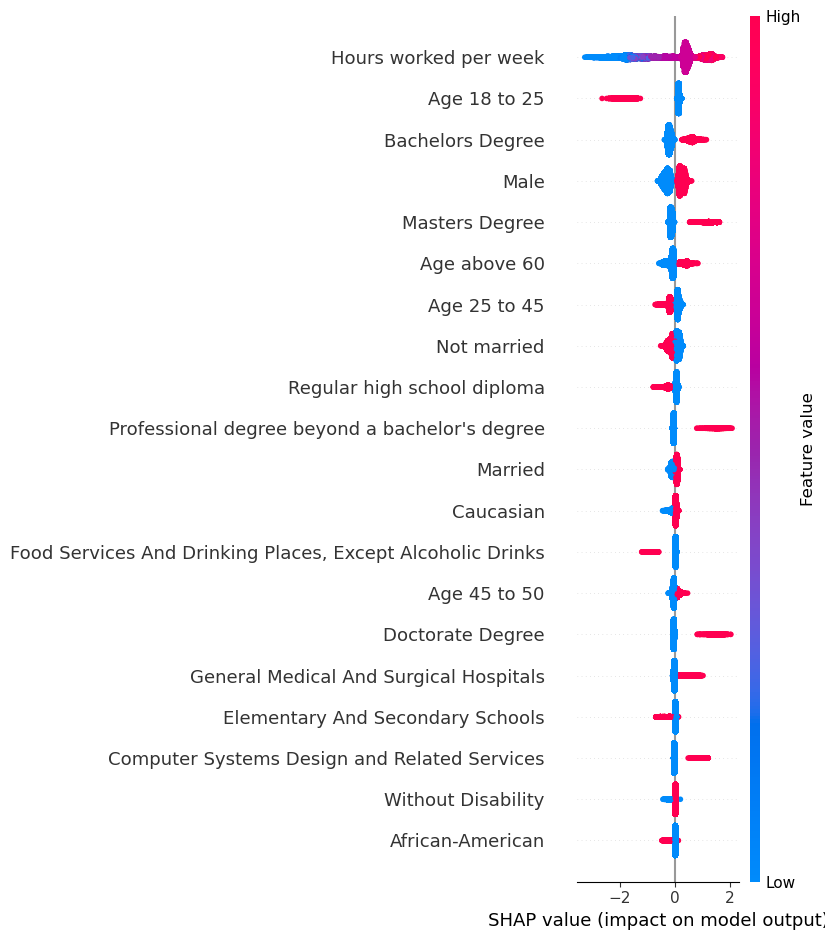

In [ ]:


shap.summary_plot(shap_values_income, X_test_income_df, max_display=20)

### Health care classifier

In [18]:
best_model_health = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **params_health
)
best_model_health.fit(X_train_health, y_train_health)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6943386448447411), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=np.float64(1.3567451588694794), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.2586212527455788), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=316, n_jobs=-1,
              num_parallel_tree=None, ...)

In [77]:
health_explainer = shap.Explainer(best_model_health, feature_names = all_feature_names_health)
shap_values_health = health_explainer(X_test_health)

In [78]:
with open("treeshap_values_health.pkl", "wb") as f:
    pickle.dump(shap_values_health, f)

In [19]:
y_pred_health = best_model_health.predict(X_test_health)
test_auc= roc_auc_score(y_test_health, y_pred_health)
print(f"Test AUC: {test_auc:.3g}")
print("Accuracy:", accuracy_score(y_test_health, y_pred_health))
print("Classification Report:\n", classification_report(y_test_health, y_pred_health, digits=3))






Test AUC: 0.556
Accuracy: 0.9111733333333333
Classification Report:
               precision    recall  f1-score   support

           0      0.476     0.126     0.200      6578
           1      0.922     0.987     0.953     68422

    accuracy                          0.911     75000
   macro avg      0.699     0.556     0.576     75000
weighted avg      0.882     0.911     0.887     75000



In [41]:
eval_df_health = X_test_h.copy()
eval_df_health["y_true"] = y_test_health.values
eval_df_health["y_pred"] = y_pred_health


In [79]:
inc2 = preprocessor2.get_feature_names_out()

# Remove "cat__" and "remainder__"
clean_feature_names2 = [name.replace("cat__", "").replace("remainder__", "") for name in inc2]


In [ ]:
results_df = pd.DataFrame(X_test_health.toarray(), columns=clean_feature_names2)

results_df['y_true'] = y_test_health.values
results_df['y_pred'] = y_pred_health

results_df.to_csv('health_test_predictions_XGBoost.csv', index=False)

In [80]:
mean_abs_shap_health = np.abs(shap_values_health.values).mean(axis=0)

top_20_idx = np.argsort(mean_abs_shap_health)[-20:][::-1]

original_feature_names = shap_values_health.feature_names
top_20_features = np.array(original_feature_names)[top_20_idx]

custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}



renamed_features = [
    custom_names.get(name, name)
    for name in original_feature_names
]
shap_values_health.feature_names = renamed_features

In [ ]:
original_feature_names = original_feature_names[:305]
renamed_features = renamed_features[:305]

In [82]:
X_test_health_df = pd.DataFrame(X_test_health.toarray(), columns=original_feature_names)  # Use toarray() if sparse

X_test_health_df.columns = renamed_features

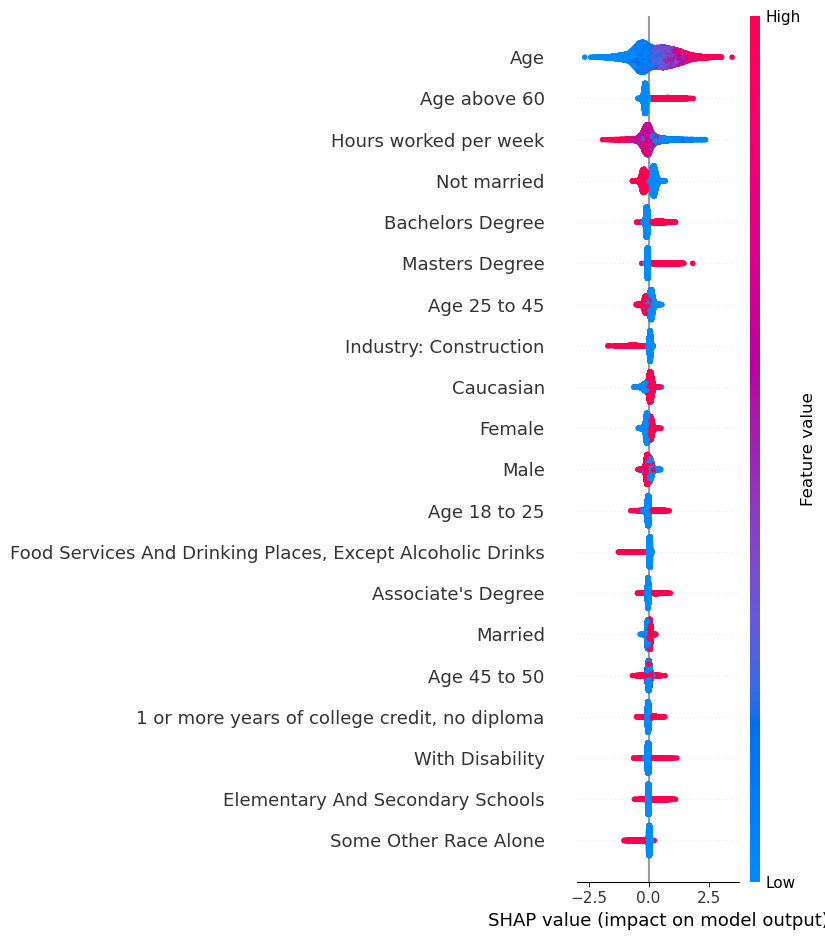

In [ ]:
shap.summary_plot(shap_values_health, X_test_health_df, max_display=20)

## Simple FFNN

In [ ]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

def train_ffnn_for_task(X_train, y_train, X_val, y_val, input_dim, n_iter=10, random_state=42):
    np.random.seed(random_state)

    param_dist = {
        'hidden_units': [32, 64],
        'dropout_rate': [0.2, 0.3, 0.4],
        'learning_rate': [1e-2, 1e-3, 1e-4],
        'batch_size': [32, 64],
        'epochs': [10, 20]
    }

    # gridsearch
    def sample_params(param_dist):
        return {k: np.random.choice(v) for k, v in param_dist.items()}

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(zip(np.unique(y_train), cw))

    results = []

    for i in range(n_iter):
        params = sample_params(param_dist)
        print(f"Trial {i+1}/{n_iter} with params: {params}")

        model = build_ffnn(
            input_dim=input_dim,
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0,
            class_weight=class_weights
        )

        val_preds = model.predict(X_val).ravel()
        val_auc = roc_auc_score(y_val, val_preds)
        print(f"Val AUC: {val_auc:.4f}\n")

        results.append((params, val_auc))

    best_params, best_val_auc = max(results, key=lambda x: x[1])
    print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")

    best_model = build_ffnn(
        input_dim=input_dim,
        hidden_units=best_params['hidden_units'],
        dropout_rate=best_params['dropout_rate'],
        learning_rate=best_params['learning_rate']
    )

    best_model.fit(
        X_train, y_train,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        verbose=0,
        class_weight=class_weights
    )

    return best_model, best_params, best_val_auc


In [ ]:
## Start gridsearch for income model

input_dim_income = X_train_income.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_income, params_income, auc_income = train_ffnn_for_task(
    X_train_income, y_train_income, X_val_income, y_val_income, input_dim_income
)

### Income model with given params

In [ ]:
# income params obtained through gridsearch
best_params_income = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}

In [17]:
ffnn_model_income = build_ffnn(
    input_dim=X_train_income.shape[1], 
    hidden_units=int(best_params_income['hidden_units']),
    dropout_rate=float(best_params_income['dropout_rate']),
    learning_rate=float(best_params_income['learning_rate'])
)

In [25]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_income), y=y_train_income)
class_weights = dict(zip(np.unique(y_train_income), cw))

ffnn_model_income.fit(
    X_train_income, y_train_income,
    epochs=int(best_params_income['epochs']),
    batch_size=int(best_params_income['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_income, y_val_income)
)


Epoch 1/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8760 - loss: 0.4382 - val_AUC: 0.8747 - val_loss: 0.4384
Epoch 2/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - AUC: 0.8766 - loss: 0.4368 - val_AUC: 0.8746 - val_loss: 0.4428
Epoch 3/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - AUC: 0.8769 - loss: 0.4366 - val_AUC: 0.8748 - val_loss: 0.4375
Epoch 4/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - AUC: 0.8773 - loss: 0.4360 - val_AUC: 0.8748 - val_loss: 0.4406
Epoch 5/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - AUC: 0.8770 - loss: 0.4362 - val_AUC: 0.8750 - val_loss: 0.4368
Epoch 6/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - AUC: 0.8770 - loss: 0.4364 - val_AUC: 0.8747 - val_loss: 0.4360
Epoch 7/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8776 - loss: 0.4354 - val_AUC: 0.8750 - val_loss: 0.4357
Epoch 8/20
10938/10938 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - AUC: 0.8774 - loss: 0.4355 - val_AUC: 0.8750 - val_loss: 0.4390
Epoch 9/20
10938

In [22]:
print("\n=== Test Performance: Income ===")
test_preds_income = ffnn_model_income.predict(X_test_income).ravel()
test_auc_income = roc_auc_score(y_test_income, test_preds_income)
print(f"Test AUC: {test_auc_income:.4f}")
print(classification_report(y_test_income, test_preds_income > 0.5, digits=3))


=== Test Performance: Income ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test AUC: 0.8743
              precision    recall  f1-score   support

           0      0.835     0.795     0.815     43688
           1      0.732     0.781     0.756     31312

    accuracy                          0.789     75000
   macro avg      0.783     0.788     0.785     75000
weighted avg      0.792     0.789     0.790     75000



In [ ]:
ffnn_model_income.save('ffnn_income.keras')

In [ ]:
## Health insurance model gridsearch
input_dim_health = X_train_health.shape[1]
print("\n=== Training for Task: Insurance ===")
ffnn_model_health, params_health, auc_health = train_ffnn_for_task(
    X_train_health, y_train_health, X_val_health, y_val_health, input_dim_health
)


=== Training for Task: Insurance ===
Trial 1/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Val AUC: 0.6905

Trial 2/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.7545

Trial 3/10 with params: {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.4201

Trial 4/10 with params: {'hidden_units': np.int64(64), 'dropout_rate': np.float64(0.4), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Val AUC: 0.5516

Trial 5/10 with

### Health insurance model with given params

In [ ]:
# health insurance obtained through gridsearch
best_params_health = {'hidden_units': np.int64(32), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.0001), 'batch_size': np.int64(64), 'epochs': np.int64(10)}

In [52]:
ffnn_model_health = build_ffnn(
    input_dim=X_train_health.shape[1],  # or whatever your feature dim is
    hidden_units=int(best_params_health['hidden_units']),
    dropout_rate=float(best_params_health['dropout_rate']),
    learning_rate=float(best_params_health['learning_rate'])
)

In [53]:
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_health), y=y_train_health)
class_weights = dict(zip(np.unique(y_train_health), cw))

ffnn_model_health.fit(
    X_train_health, y_train_health,
    epochs=int(best_params_health['epochs']),
    batch_size=int(best_params_health['batch_size']),
    class_weight=class_weights,
    verbose=1,
    validation_data=(X_val_health, y_val_health)
)

Epoch 1/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - AUC: 0.5213 - loss: 222.6752 - val_AUC: 0.4229 - val_loss: 2.5138
Epoch 2/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6015 - loss: 4.8405 - val_AUC: 0.4375 - val_loss: 1.6326
Epoch 3/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6260 - loss: 1.4080 - val_AUC: 0.7086 - val_loss: 0.6535
Epoch 4/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6429 - loss: 0.8985 - val_AUC: 0.7007 - val_loss: 0.6157
Epoch 5/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - AUC: 0.6825 - loss: 0.6627 - val_AUC: 0.6989 - val_loss: 0.7037
Epoch 6/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - AUC: 0.6724 - loss: 0.6556 - val_AUC: 0.7133 - val_loss: 0.5595
Epoch 7/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - AUC: 0.6901 - loss: 0.6392 - val_AUC: 0.7504 - val_loss: 0.7184
Epoch 8/10
5469/5469 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - AUC: 0.6995 - loss: 0.6330 - val_AUC: 0.7480 - val_loss: 0.6279
Epoch 9/10
5469/5469 ━━━━━━━━━

In [60]:
ffnn_model_health.save('ffnn_health.keras')

In [ ]:
# test set evluation
print("\n=== Test Performance: Insurance ===")
test_preds_health = ffnn_model_health.predict(X_test_health).ravel()
test_auc_health = roc_auc_score(y_test_health, test_preds_health)
print(f"Test AUC: {test_auc_health:.4f}")
print(classification_report(y_test_health, test_preds_health > 0.5, digits=3))



=== Test Performance: Insurance ===
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Test AUC: 0.7665
              precision    recall  f1-score   support

           0      0.130     0.906     0.227      6578
           1      0.979     0.417     0.584     68422

    accuracy                          0.460     75000
   macro avg      0.554     0.661     0.406     75000
weighted avg      0.904     0.460     0.553     75000



In [ ]:
# save data for further fairness evaluation
np.savez(
    "ffnn_income_data.npz",
    X_test=X_test_income.toarray() if hasattr(X_test_income, 'toarray') else X_test_income,
    y_true=y_test_income,
    y_pred=test_preds_income
)

In [ ]:
np.savez(
    "ffnn_health_data.npz",
    X_test=X_test_health.toarray() if hasattr(X_test_health, 'toarray') else X_test_health,
    y_true=y_test_health,
    y_pred=test_preds_health)


## DeepSHAP

### Income

In [ ]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_income, y_train_income))
 
# stratified sample from test set
X_test_array = X_test_income.toarray() if hasattr(X_test_income, "toarray") else X_test_income
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx_income = next(sss_test.split(X_test_array, y_test_income))
X_test_sample_income = X_test_array[test_sample_idx_income]
 
# set background data
background = X_train_income[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_income_NN = shap.DeepExplainer(ffnn_model_income, background)
deep_shap_values_income = explainer_income_NN.shap_values(X_test_sample_income).squeeze(-1)

In [ ]:
custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'SCHL_18':'Some College, Less Than One Year',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}


# Map custom names to all features
renamed_features_income = [custom_names.get(name, name) for name in all_feature_names_income]

# Convert input data to a DataFrame with renamed columns
X_test_income_df = pd.DataFrame(X_test_sample_income, columns=renamed_features_income)


C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3121749230.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_income, X_test_income_df, max_display=20)


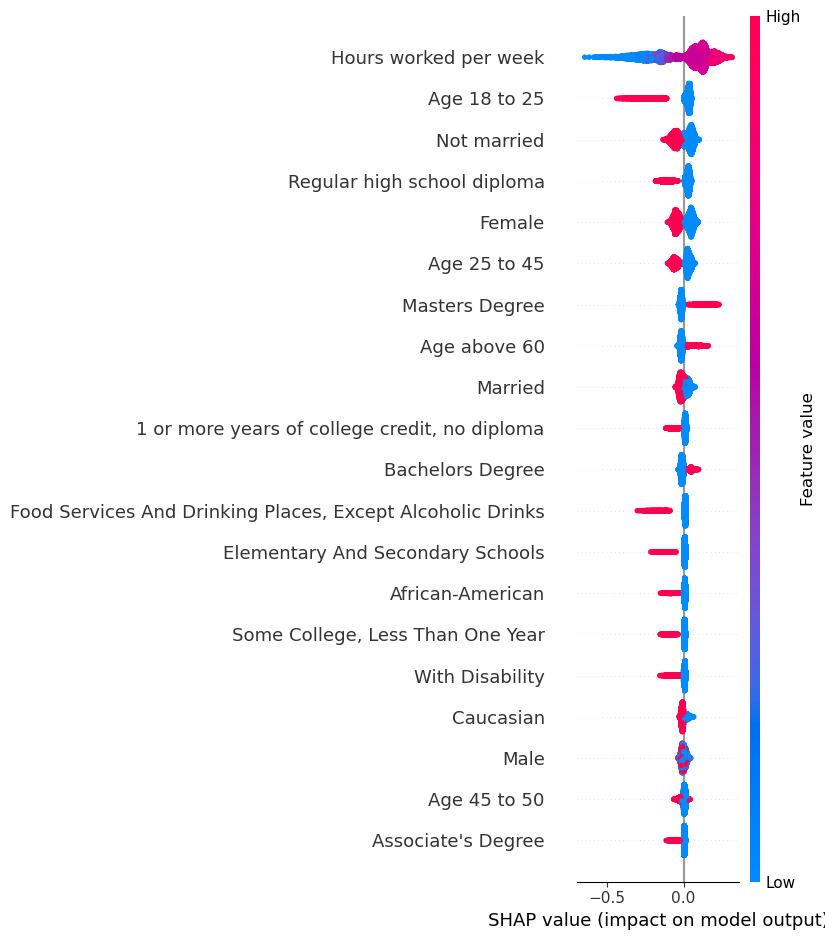

In [ ]:
shap.summary_plot(deep_shap_values_income, X_test_income_df, max_display=20)

In [29]:
# locally saving shap values
np.save("deepshap_values_income.npy", deep_shap_values_income)
np.save("deepshap_income_idx.npy", test_sample_idx_income)

with open("deepshap_values_income.pkl", "wb") as f:
    pickle.dump(deep_shap_values_income, f)

In [ ]:
# Save encoded test data
df_x_test_sample = pd.DataFrame(X_test_sample_income, columns=all_feature_names_income)
df_x_test_sample.to_csv('X_test_sample_income.csv', index=False)

In [ ]:
# save raw test data
df_x_test_sample = pd.DataFrame(X_test_inc, columns=all_feature_names_income)
df_x_test_sample.to_csv('X_test_sample_inc.csv', index=False)

In [ ]:
#save background data
df_x_background = pd.DataFrame(background, columns= all_feature_names_income)
df_x_background.to_csv('X_background_income.csv', index=False)

### Health insurance

In [ ]:
# sample representative background set and sample size
background_size = 5000
test_sample_size = 10000
 
# stratified sample from training set
sss_train = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss_train.split(X_train_health, y_train_health))
 
# stratified sample from test set
X_test_array = X_test_health.toarray() if hasattr(X_test_health, "toarray") else X_test_health
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=test_sample_size, random_state=42)
_, test_sample_idx_health = next(sss_test.split(X_test_array, y_test_health))
X_test_sample_health = X_test_array[test_sample_idx_health]
 
# set background
background = X_train_health[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background
 
# DeepSHAP
explainer_health_NN = shap.DeepExplainer(ffnn_model_health, background)
deep_shap_values_health = explainer_health_NN.shap_values(X_test_sample_health).squeeze(-1)

C:\Users\odiee\AppData\Local\Temp\ipykernel_14980\3746504667.py:47: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(deep_shap_values_health, X_test_health_df, max_display=20)


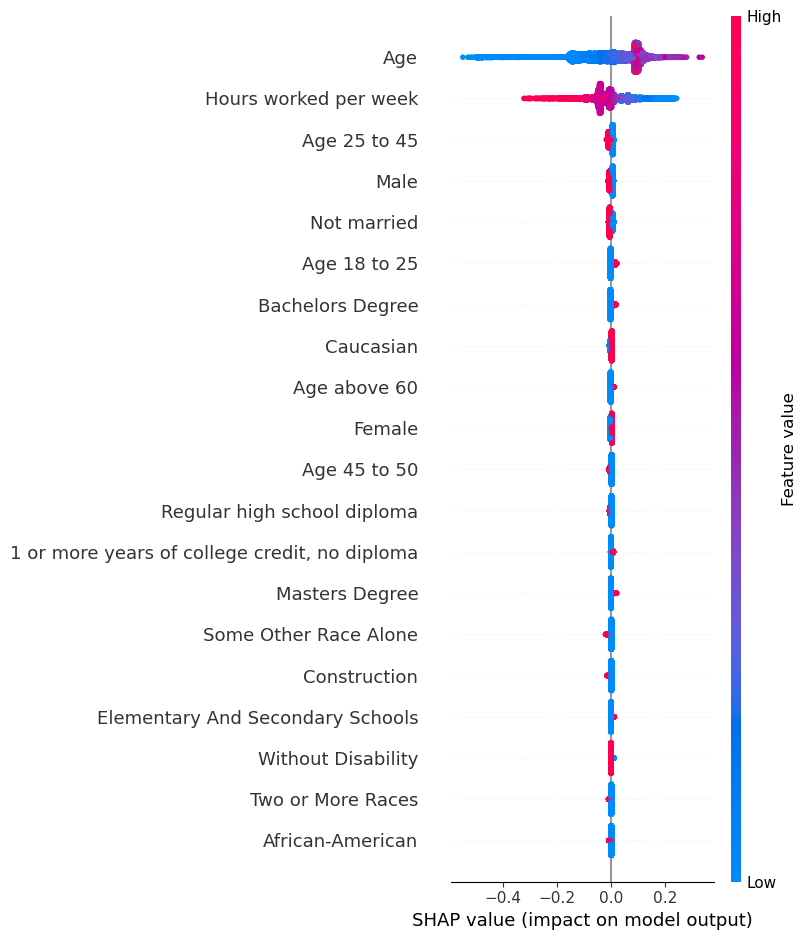

In [ ]:
custom_names = {
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1': 'Male',
    'SEX_2': 'Female',
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'NAICSP_23': 'Construction',
    'PINCP': 'Income',
    'WKHP': 'Hours worked per week',
    'AGEP_25_45': 'Age 25 to 45',
    'AGEP_18_25': 'Age 18 to 25',
    'AGEP_60_plus': 'Age above 60',
    'MAR_1': 'Married', 
    'SCHL_21': 'Bachelors Degree',
    'SCHL_16':'Regular high school diploma',
    'SCHL_23':'Professional degree beyond a bachelor\'s degree',
    'DIS_1': 'With Disability',
    'SCHL_22': 'Masters Degree',
    'MAR_0': 'Not married',
    'RAC1P_1': 'Caucasian',
    'NAICSP_722Z': 'Food Services And Drinking Places, Except Alcoholic Drinks',
    'DIS_2': 'Without Disability',
    'RAC1P_2': 'African-American',
    'SCHL_24': 'Doctorate Degree',
    'NAICSP_622M': 'General Medical And Surgical Hospitals',
    'NAICSP_6111': 'Elementary And Secondary Schools',
    'NAICSP_5415': 'Computer Systems Design and Related Services',
    'AGEP_45_60': 'Age 45 to 50',
    'RAC1P_8': 'Some Other Race Alone',
    'RAC1P_9': 'Two or More Races',
    'SCHL_18':'Some College, Less Than One Year',
    'SCHL_19':'1 or more years of college credit, no diploma',
    'SCHL_20':'Associate\'s Degree'
}


# Map custom names to all features
renamed_features_health = [custom_names.get(name, name) for name in all_feature_names_health[:305]]

# Convert input data to a DataFrame with renamed columns
X_test_health_df = pd.DataFrame(X_test_sample_health, columns=renamed_features_health)
shap.summary_plot(deep_shap_values_health, X_test_health_df, max_display=20)


In [56]:
# locally saving shap values
np.save("deepshap_values_health.npy", deep_shap_values_health
        )
np.save("deepshap_health_idx.npy", test_sample_idx_health)


In [ ]:
# Save encoded test data
df_x_test_sample = pd.DataFrame(X_test_sample_health, columns=all_feature_names_health[:305])
df_x_test_sample.to_csv('X_test_sample_health.csv', index=False)


In [ ]:
# save raw test data
df_x_test_sample = pd.DataFrame(X_test_h, columns=all_feature_names_health[:305])
df_x_test_sample.to_csv('X_test_sample_h.csv', index=False)

In [ ]:
# save background data
df_x_background = pd.DataFrame(background, columns= all_feature_names_health[:305])
df_x_background.to_csv('X_background_health.csv', index=False)

# Statistics

In [34]:
def cliffs_delta(x, y): 
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0:
        return np.nan
    diff = x[:, None] - y
    return (np.sum(diff > 0) - np.sum(diff < 0)) / (nx * ny)

In [ ]:
# extracts subgroups and creates masks for each subgroup to obtain specific SHAP value vectors for each subgroup

def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9],
        'MAR': [0, 1],
        'AGEP': ['18_25', '25_45', '45_60', '60_plus'],
        'DIS': [1, 2]
    }

    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values

    return subgroups


## DeepSHAP statistics

#### Income

In [115]:
shap_values_dp_income = np.load("deepshap_values_income.npy")

In [116]:
test_sample_idx_income = np.load('deepshap_income_idx.npy')

In [ ]:
# obtain the correct samples as performed with building the DeepSHAP explainer
X_test_sample_income_raw = X_test_inc.iloc[test_sample_idx_income]

#### Health insurance

In [135]:
shap_values_dp_health = np.load("deepshap_values_health.npy")

In [ ]:
# obtain the correct samples as performed with building the DeepSHAP explainer
X_test_sample_health_raw = X_test_h.iloc[test_sample_idx_health]

### Labelling

In [ ]:
data = """
211: EXT-Oil And Gas Extraction
2121: EXT-Coal Mining
2122: EXT-Metal Ore Mining
2123: EXT-Nonmetallic Mineral Mining And Quarrying
213: EXT-Support Activities For Mining
2211P: UTL-Electric Power Generation, Transmission And Distribution
2212P: UTL-Natural Gas Distribution
22132: UTL-Sewage Treatment Facilities
2213M: UTL-Water Supply And Irrigation Systems, And Steam And Air-Conditioning Supply
221MP: UTL-Electric And Gas, And Other Combinations
22S: UTL-Not Specified Utilities
23: CON-Construction (The Cleaning Of Buildings And Dwellings Is Incidental During Construction And Immediately After Construction)
3113: MFG-Sugar And Confectionery Products
3114: MFG-Fruit And Vegetable Preserving And Specialty Food Manufacturing
3115: MFG-Dairy Product Manufacturing
3116: MFG-Animal Slaughtering And Processing
311811: MFG-Retail Bakeries
3118Z: MFG-Bakeries And Tortilla Manufacturing, Except Retail Bakeries
311M1: MFG-Animal Food, Grain And Oilseed Milling
311M2: MFG-Seafood And Other Miscellaneous Foods, N.E.C.
311S: MFG-Not Specified Food Industries
3121: MFG-Beverage Manufacturing
3122: MFG-Tobacco Manufacturing
3131: MFG-Fiber, Yarn, And Thread Mills
3132Z: MFG-Fabric Mills, Except Knit Fabric Mills
3133: MFG-Textile And Fabric Finishing And Fabric Coating Mills
31411: MFG-Carpet And Rug Mills
314Z: MFG-Textile Product Mills, Except Carpet And Rug
315M: MFG-Cut And Sew, And Apparel Accessories And Other Apparel Manufacturing
3162: MFG-Footwear Manufacturing
316M: MFG-Leather And Hide Tanning And Finishing, And Other Leather And Allied Product Manufacturing
31M: MFG-Knit Fabric Mills, And Apparel Knitting Mills
3211: MFG-Sawmills And Wood Preservation
3212: MFG-Veneer, Plywood, And Engineered Wood Product Manufacturing
32199M: MFG-Manufactured Home (Mobile Home) And Prefabricated Wood Building Manufacturing
3219ZM: MFG-Miscellaneous Wood Product Manufacturing
3221: MFG-Pulp, Paper, And Paperboard Mills
32221: MFG-Paperboard Container Manufacturing
3222M: MFG-Miscellaneous Paper And Pulp Products Manufacturing
3231: MFG-Printing And Related Support Activities
32411: MFG-Petroleum Refineries
3241M: MFG-Petroleum And Coal Products Manufacturing, Except Petroleum Refineries
3252: MFG-Resin, Synthetic Rubber, And Artificial And Synthetic Fibers And Filaments Manufacturing
3253: MFG-Pesticide, Fertilizer, And Other Agricultural Chemical Manufacturing
3254: MFG-Pharmaceutical And Medicine Manufacturing
3255: MFG-Paint, Coating, And Adhesive Manufacturing
3256: MFG-Soap, Cleaning Compound, And Toilet Preparation Manufacturing
325M: MFG-Basic Chemical Manufacturing, And Other Chemical Product And Preparation Manufacturing
3261: MFG-Plastics Product Manufacturing
32621: MFG-Tire Manufacturing
3262M: MFG-Rubber Products, Except Tires, Manufacturing
32711: MFG-Pottery, Ceramics, And Plumbing Fixture Manufacturing
32712: MFG-Clay Building Material And Refractories Manufacturing
3272: MFG-Glass And Glass Product Manufacturing
3279: MFG-Other Nonmetallic Mineral Product Manufacturing
327M: MFG-Cement, Concrete, Lime, And Gypsum Product Manufacturing
3313: MFG-Alumina And Aluminum Production And Processing
3314: MFG-Nonferrous Metal (Except Aluminum) Production And Processing
3315: MFG-Foundries
331M: MFG-Iron And Steel Mills And Steel Product Manufacturing
3321: MFG-Forging And Stamping
3322: MFG-Cutlery And Handtool Manufacturing
3327: MFG-Machine Shops; Turned Product; Screw, Nut, And Bolt Manufacturing
3328: MFG-Coating, Engraving, Heat Treating, And Allied Activities
33299M: MFG-Ordnance
332M: MFG-Architectural And Structural Metals, And Boiler, Tank, And Shipping Container Manufacturing
332MZ: MFG-Miscellaneous Fabricated Metal Product Manufacturing
33311: MFG-Agricultural Implement Manufacturing
3331M: MFG-Construction, And Mining And Oil And Gas Field Machinery Manufacturing
3333: MFG-Commercial And Service Industry Machinery Manufacturing
3335: MFG-Metalworking Machinery Manufacturing
3336: MFG-Engine, Turbine, And Power Transmission Equipment Manufacturing
333MS: MFG-Machinery Manufacturing, N.E.C. Or Not Specified
3341: MFG-Computer And Peripheral Equipment Manufacturing
3345: MFG-Navigational, Measuring, Electromedical, And Control Instruments Manufacturing
334M1: MFG-Communications, Audio, And Video Equipment Manufacturing
334M2: MFG-Semiconductor, Magnetic And Optical Media, And Other Electronic Component Manufacturing
3352: MFG-Household Appliance Manufacturing
335M: MFG-Electric Lighting And Electrical Equipment Manufacturing, And Other Electrical Component Manufacturing, N.E.C.
33641M1: MFG-Aircraft, Aircraft Engine, And Aircraft Parts Manufacturing
33641M2: MFG-Guided Missile And Space Vehicle And Parts Manufacturing
3365: MFG-Railroad Rolling Stock Manufacturing
3366: MFG-Ship And Boat Building
3369: MFG-Other Transportation Equipment Manufacturing
336M: MFG-Motor Vehicles And Motor Vehicle Equipment Manufacturing
337: MFG-Furniture And Related Product Manufacturing
3391: MFG-Medical Equipment And Supplies Manufacturing
3399M: MFG-Sporting And Athletic Goods, And Doll, Toy And Game Manufacturing
3399ZM: MFG-Miscellaneous Manufacturing, N.E.C.
33MS: MFG-Not Specified Metal Industries
3MS: MFG-Not Specified Manufacturing Industries
4231: WHL-Motor Vehicle And Motor Vehicle Parts And Supplies Merchant Wholesalers
4232: WHL-Furniture And Home Furnishing Merchant Wholesalers
4233: WHL-Lumber And Other Construction Materials Merchant Wholesalers
4234: WHL-Professional And Commercial Equipment And Supplies Merchant Wholesalers
4235: WHL-Metal and Mineral, Except Petroleum, Merchant Wholesalers
4236: WHL-Household Appliances And Electrical And Electronic Goods Merchant Wholesalers
4237: WHL-Hardware, And Plumbing And Heating Equipment, And Supplies Merchant Wholesalers
4238: WHL-Machinery, Equipment, And Supplies Merchant Wholesalers
42393: WHL-Recyclable Material Merchant Wholesalers
4239Z: WHL-Miscellaneous Durable Goods, Except Recyclable Material, Merchant Wholesalers
4241: WHL-Paper and Paper Product Merchant Wholesalers
4243: WHL-Apparel, Piece Goods, And Notions Merchant Wholesalers
4244: WHL-Grocery And Related Product Merchant Wholesalers
4245: WHL-Farm Product Raw Material Merchant Wholesalers
4247: WHL-Petroleum And Petroleum Products Merchant Wholesalers
4248: WHL-Beer, Wine, And Distilled Alcoholic Beverage Merchant Wholesalers
42491: WHL-Farm Supplies Merchant Wholesalers
4249Z: WHL-Miscellaneous Nondurable Goods Merchant, Except Farm Supplies, Wholesalers
424M: WHL-Drugs, Druggists' Sundries, And Chemical And Allied Products Merchant Wholesalers
4251: WHL-Wholesale Trade Agents And Brokers
42S: WHL-Not Specified Wholesale Trade
4411: RET-Automobile Dealers
4412: RET-Other Motor Vehicle Dealers
4413: RET-Automotive Parts, Accessories, And Tire Retailers
44414: RET-Hardware Retailers
4441Z: RET-Building Material And Supplies Dealers, Except Hardware Retailers
4442: RET-Lawn And Garden Equipment And Supplies Retailers
44511: RET-Supermarkets And Other Grocery (Except Convenience) Retailers
44513: RET-Convenience Retailers And Vending Machine Operators
4452: RET-Specialty Food Retailers
4453: RET-Beer, Wine, And Liquor Retailers
4491: RET-Furniture And Home Furnishings Retailers
4492: RET-Electronics And Appliance Retailers
4551: RET-Department Stores
4552: RET-Warehouse Clubs, Supercenters, And Other General Merchandise Retailers
45611: RET-Pharmacies And Drug Retailers
4561Z: RET-Health And Personal Care, Except Pharmacies And Drug, Retailers
4571: RET-Gasoline Stations
4572: RET-Fuel Dealers
4581: RET-Clothing And Clothing Accessories Retailers
4582: RET-Shoe Retailers
4583: RET-Jewelry, Luggage, And Leather Goods Retailers
45913: RET-Sewing, Needlework, And Piece Goods Retailers
45914: RET-Musical Instrument And Supplies Retailers
4591M: RET-Sporting Goods, And Hobby, Toy, And Game Retailers
45921: RET-Book Retailers And News Dealers
4593: RET-Florists
45941: RET-Office Supplies And Stationery Retailers
45942: RET-Gift, Novelty, And Souvenir Retailers
4595: RET-Used Merchandise Retailers
4599: RET-Other Miscellaneous Retailers
481: TRN-Air Transportation
482: TRN-Rail Transportation
483: TRN-Water Transportation
484: TRN-Truck Transportation
4853: TRN-Taxi And Limousine Service
485M: TRN-Transit And Ground Passenger Transportation, Except Taxi And Limousine Service
486: TRN-Pipeline Transportation
487: TRN-Scenic And Sightseeing Transportation
488: TRN-Support Activities For Transportation
491: TRN-Postal Service
492: TRN-Couriers And Messengers
493: TRN-Warehousing And Storage
4MS: RET-Not Specified Retail Trade
5121: INF-Motion Pictures And Video Industries
5122: INF-Sound Recording Industries
51311: INF-Newspaper Publishers
5131Z: INF-Periodical, Book, And Directory And Mailing List, And Other Publishers
5132: INF-Software Publishers
516: INF-Broadcasting and content providers
517111: INF-Wired Telecommunications Carriers
517Z: INF-Telecommunications, Except Wired Telecommunications Carriers
5182: INF-Computing Infrastructure Providers, Data Processing, Web Hosting, And Related Services
51921: INF-Libraries And Archives
51929: INF-Web Search Portals And All Other Information Services
5221M: FIN-Credit Unions, And Savings Institutions And Other Depository Credit Intermediation
522M: FIN-Nondepository Credit Intermediation And Related Activities
5241: FIN-Insurance Carriers
5242: FIN-Agencies, Brokerages, And Other Insurance Related Activities
52M1: FIN-Monetary Authorities-Central Bank, And Commercial Banking
52M2: FIN-Securities, Commodities, Funds, Trusts, And Other Financial Investments
5313: FIN-Activities Related To Real Estate
531M: FIN-Lessors Of Real Estate, And Offices Of Real Estate Agents And Brokers
5321: FIN-Automotive Equipment Rental And Leasing
532M2: FIN-Consumer Goods Rental, And General Rental Centers
53M: FIN-Commercial And Industrial Machinery And Equipment, And Nonfinancial Intangible Assets Rental And Leasing
5411: PRF-Legal Services
5412: PRF-Accounting, Tax Preparation, Bookkeeping, And Payroll Services
5413: PRF-Architectural, Engineering, And Related Services
5414: PRF-Specialized Design Services
5415: PRF-Computer Systems Design And Related Services
5416: PRF-Management, Scientific, And Technical Consulting Services
5417: PRF-Scientific Research And Development Services
5418: PRF-Advertising, Public Relations, And Related Services
54194: PRF-Veterinary Services
5419Z: PRF-Other Professional, Scientific, And Technical, Except Veterinary, Services
55: PRF-Management Of Companies And Enterprises
5613: PRF-Employment Services
5614: PRF-Business Support Services
5615: PRF-Travel Arrangements And Reservation Services
5616: PRF-Investigation And Security Services
56173: PRF-Landscaping Services
5617Z: PRF-Services To Buildings And Dwellings, Except Landscaping Services
561M: PRF-Other Administrative And Other Support Services
562: PRF-Waste Management And Remediation Services
6111: EDU-Elementary And Secondary Schools
611M1: EDU-Junior Colleges, Colleges, Universities, And Professional Schools
611M2: EDU-Business, Trade And Technical Schools, And Computer And Management Training
611M3: EDU-Other Schools And Instruction, And Educational Support Services
6211: MED-Offices Of Physicians
6212: MED-Offices Of Dentists
62131: MED-Offices Of Chiropractors
62132: MED-Offices Of Optometrists
6213ZM: MED-Offices Of Other Health Practitioners
6214: MED-Outpatient Care Centers
6216: MED-Home Health Care Services
621M: MED-Other Health Care Services
6222: MED-Psychiatric And Substance Abuse Hospitals
622M: MED-General Medical And Surgical Hospitals, And Specialty (Except Psychiatric And Substance Abuse) Hospitals
6231: MED-Nursing Care Facilities (Skilled Nursing Facilities)
623M: MED-Residential Care Facilities, Except Skilled Nursing Facilities
6241: SCA-Individual And Family Services
6242: SCA-Community Food And Housing, And Emergency And Other Relief Services
6243: SCA-Vocational Rehabilitation Services
6244: SCA-Child Care Services
7111: ENT-Performing Arts Companies
7112: ENT-Spectator Sports
7115: ENT-Independent Artists, Writers, And Performers
711M: ENT-Promoters Of Performing Arts, Sports, And Similar Events, Agents And Managers For Artists, Athletes, Entertainers, And Other Public Figures
712: ENT-Museums, Historical Sites, And Similar Institutions
71395: ENT-Bowling Centers
713Z: ENT-Other Amusement, Gambling, And Recreation Industries
7211: ENT-Traveler Accommodation
721M: ENT-Recreational Vehicle Parks And Camps, And Rooming And Boarding Houses, Dormitories, And Workers' Camps
7224: ENT-Drinking Places (Alcoholic Beverages)
722Z: ENT-Food Services And Drinking Places, Except Alcoholic Beverages
811192: SRV-Car Washes
8111Z: SRV-Automotive Repair And Maintenance, Except Car Washes
8112: SRV-Electronic And Precision Equipment Repair And Maintenance
8113: SRV-Commercial And Industrial Machinery And Equipment Repair And Maintenance
8114: SRV-Personal And Household Goods Repair And Maintenance
812111: SRV-Barber Shops
812112: SRV-Beauty Salons
8121M: SRV-Nail Salons And Other Personal Care Services
8122: SRV-Death Care Services
8123: SRV-Drycleaning And Laundry Services
8129: SRV-Other Personal Services
8131: SRV-Religious Organizations
81393: SRV-Labor Unions And Similar Labor Organizations
8139Z: SRV-Business, Professional, Political, And Similar Organizations
813M: SRV-Civic, Social, Advocacy Organizations, And Grantmaking And Giving Services
814: SRV-Private Households
92113: ADM-Public Finance Activities
92119: ADM-Other General Government And Support
9211MP: ADM-Executive Offices And Legislative Bodies
923: ADM-Administration Of Human Resource Programs
92811P1: MIL-U.S. Army
92811P2: MIL-U.S. Air Force
92811P3: MIL-U.S. Navy
92811P4: MIL-U.S. Marines
92811P5: MIL-U.S. Coast Guard
92811P6: MIL-Armed Forces, Branch Not Specified
92811P7: MIL-Military Reserves Or National Guard
9281P: ADM-National Security And International Affairs
92M1: ADM-Administration Of Environmental Quality, And Housing Programs, Urban Planning And Community Development
92M2: ADM-Administration Of Economic Programs And Space Research And Technology
92MP: ADM-Justice, Public Order, And Safety Activities

"""

naics_dict = {}

for line in data.strip().split('\n'):
    # Split at the first colon ':'
    code, description = line.split(':', 1)
    code = code.strip()
    description = description.strip()

    # Compose the key with "NAICSP_" prefix
    key = f"NAICSP_{code}"

    naics_dict[key] = description

NAICSP_211: "EXT-Oil And Gas Extraction"
NAICSP_2121: "EXT-Coal Mining"
NAICSP_2122: "EXT-Metal Ore Mining"
NAICSP_2123: "EXT-Nonmetallic Mineral Mining And Quarrying"
NAICSP_213: "EXT-Support Activities For Mining"


In [20]:
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
AGEP = {
    '18_25': 'Age 18–25',
    '25_45': 'Age 25–45',
    '45_60': 'Age 45–60',
    '60_plus': 'Age 60+'
}
DIS = {1: "With disability", 2: "Without disability"}
NAICS = naics_dict

### Non-parametric assumptions

In [ ]:
# map feature name with full feature description for easier interpreation later on
def map_feature_name(feature):
    try:
        parts = feature.split('_')
        if parts[0] == 'AGEP':
            category_name = '_'.join(parts[1:])
            return AGEP.get(category_name, feature)
        else:
            target = parts[0]
            index = int(parts[1])
            return (
                SCHL[index] if target == 'SCHL' else
                MAR[index] if target == 'MAR' else
                RELP[index] if target == 'RELP' else
                SEX[index] if target == 'SEX' else
                RAC1P[index] if target == 'RAC1P' else
                DIS[index] if target == 'DIS' else
                naics_dict.get(index, feature)
            )
    except:
        if feature == 'WKHP':
            return "working hours per week"
        return feature

In [ ]:
## function where the SHAP values vector for each subgroup is extracted using masks, after which several statistical tests are performed

def t_test_all_subgroups(df, filter_names, shap_values, attr1, attr2):
    subgroup_masks = extract_subgroups(df, attr1, attr2)
    shap_values_np = shap_values if isinstance(shap_values, np.ndarray) else shap_values.to_numpy()
    results = []
    removed_instances = 0

    subgroup_items = list(subgroup_masks.items())
    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_items, 2):
        if mask1.sum() < 2 or mask2.sum() < 2:
            removed_instances +=1
            continue

        shap1 = shap_values_np[mask1]
        shap2 = shap_values_np[mask2]

        # check if subgroup has any SHAP values at all
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        def process_feature(i):
            group1 = shap1[:, i]
            group2 = shap2[:, i]

            stat_u, p_mwu = mannwhitneyu(group1, group2, alternative='two-sided')
            # if the p val is not statistically significant, move to the next shap values
            if p_mwu >= 0.05:
                return None

            effect_size = cliffs_delta(group1, group2)
            if np.isnan(effect_size):
                return None

            return {
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': filter_names[i],
                'feature description': map_feature_name(filter_names[i]),
                'u-test statistic': stat_u,
                'mwu_p': p_mwu,
                'effect_size': effect_size,
                'mean_diff': group1.mean() - group2.mean()
            }

        # use parallel processing for faster execution on CPU
        with ThreadPoolExecutor(max_workers=2) as executor:
            future_results = executor.map(process_feature, range(shap1.shape[1]))
            results.extend(filter(None, future_results))
    
    print("Number of removed instances:", removed_instances)
    return pd.DataFrame(results)

In [ ]:
# NAICS recode mapping for statistical results
mapping_df = pd.read_excel('2023-ACS-PUMS-and-2024-SIPP-Public-Use-Industry-Code-List.xlsx', skiprows=18)
filtered_mapping = mapping_df[['Industry 2022 Description', '2022 NAICS Based Code']]
filtered_mapping = filtered_mapping.dropna(subset=['Industry 2022 Description', '2022 NAICS Based Code'])
filtered_mapping.columns = ['Description', 'NAICS']
filtered_mapping['NAICS'] = filtered_mapping['NAICS'].astype(str).str.strip()
filtered_mapping.reset_index(drop=True, inplace=True)

In [231]:
NAICS_list = dict(zip(filtered_mapping['NAICS'], filtered_mapping['Description']))

In [ ]:
def safe_float_string(key):
    try:
        return f"NAICSP_{float(key)}"
    except ValueError:
        return f"NAICSP_{key}"

naics_keys = [safe_float_string(key) for key in NAICS_list.keys()]

schl_keys = [f"SCHL_{float(key)}" for key in SCHL.keys()]
all_filter_names = [*naics_keys, *schl_keys]
filter_names = [name for name in all_filter_names if name in all_feature_names_income]

# find index of features 
filter_indices = [i for i, feat in enumerate(all_feature_names_income) if feat in filter_names]


In [ ]:
filtered_deepshap_values_income = shap_values_dp_income[:, filter_indices]

In [ ]:
filtered_deepshap_values_health = shap_values_dp_health[:, filter_indices]

In [ ]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

# income and health insurance data sets are run separately

results_dict = {}  # key: 'health_mar_sex', value: DataFrame

for attr1, attr2 in attr_combinations:
    print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

    try:
        df_result_deepshap = t_test_all_subgroups(X_test_sample_health_raw, filter_names, filtered_deepshap_values_health, attr1=attr1, attr2=attr2)
        #df_result_deepshap = t_test_all_subgroups(X_test_sample_income_raw, filter_names, filtered_deepshap_values_income, attr1=attr1, attr2=attr2)
        df_result_deepshap['attr1'] = attr1
        df_result_deepshap['attr2'] = attr2
        result_key = f"{attr1.lower()}_{attr2.lower()}"
        results_dict[result_key] = df_result_deepshap

        # filter for significant results and moderate effect size
        significant_results = df_result_deepshap[(df_result_deepshap['mwu_p'] < 0.05) & ((df_result_deepshap['effect_size'] >= 0.33) | (df_result_deepshap['effect_size'] <= -0.33))]

        significant_results = significant_results.sort_values(by='effect_size', ascending=False)

        if significant_results.empty:
            print("No significant results")
        else:
            print(significant_results[['feature', 'feature description', 'subgroup1', 'subgroup2', 'effect_size', 'mwu_p']].head(20))

    except KeyError as e:
        print(f"Skipped due to missing column: {e}")
    except Exception as e:
        print(f"Error processing {attr1} x {attr2}: {e}")

    


---- Analyzing Subgroups: RAC1P x SEX ----
Number of removed instances: 0
             feature feature description      subgroup1      subgroup2  \
879      NAICSP_335M         NAICSP_335M  RAC1P_1_SEX_2  RAC1P_8_SEX_1   
2274     NAICSP_33MS         NAICSP_33MS  RAC1P_6_SEX_2  RAC1P_8_SEX_1   
883    NAICSP_32199M       NAICSP_32199M  RAC1P_1_SEX_2  RAC1P_8_SEX_1   
957      NAICSP_335M         NAICSP_335M  RAC1P_1_SEX_2  RAC1P_8_SEX_2   
2278     NAICSP_335M         NAICSP_335M  RAC1P_6_SEX_2  RAC1P_8_SEX_1   
875      NAICSP_33MS         NAICSP_33MS  RAC1P_1_SEX_2  RAC1P_8_SEX_1   
2282   NAICSP_32199M       NAICSP_32199M  RAC1P_6_SEX_2  RAC1P_8_SEX_1   
1962     NAICSP_33MS         NAICSP_33MS  RAC1P_6_SEX_1  RAC1P_8_SEX_1   
1999    NAICSP_611M1        NAICSP_611M1  RAC1P_6_SEX_1  RAC1P_8_SEX_1   
2333  NAICSP_92811P5      NAICSP_92811P5  RAC1P_6_SEX_2  RAC1P_8_SEX_1   
2356     NAICSP_335M         NAICSP_335M  RAC1P_6_SEX_2  RAC1P_8_SEX_2   
2326   NAICSP_9211MP       NAICSP_921

In [ ]:
# function to help the filtering of non-existing subgroup pair = feature value combinations
def parse_subgroup_name(subgroup_name):
    parts = subgroup_name.split("_")

    if "AGEP" in parts: # for AGEP
        agep_index = parts.index("AGEP")
        start_age = parts[agep_index + 1]
        end_age = parts[agep_index + 2]

        condition1 = "AGEP"
        condition1_val = f'{start_age}_{end_age}'
        
        condition2_index = 0 if agep_index == 2 else 3 if agep_index == 0 else None
        condition2= parts[condition2_index]
        condition2_val = int(parts[condition2_index+1])

    else:
        condition1 = parts[0]
        condition1_val = int(parts[1])
        condition2 = parts[2]
        condition2_val = int(parts[3])

    return condition1, condition1_val, condition2, condition2_val

In [ ]:
#filtered_results_dict_deepshap_health = {}
filtered_results_dict_deepshap_income = {}

for key, results in results_dict.items():
    n_removed = 0
    filtered_rows = []

    for _, row in results.iterrows():
        subgroup1 = row['subgroup1']
        subgroup2 = row['subgroup2']
        feature = row['feature']

        cond1_1, cond1_val1, cond2_1, cond2_val1 = parse_subgroup_name(subgroup1)
        cond1_2, cond1_val2, cond2_2, cond2_val2 = parse_subgroup_name(subgroup2)

        legit_key, legit_val = feature.split("_")

        subgroup1_exists = (
            ((X_test_sample_health_raw[cond1_1] == cond1_val1) & (X_test_sample_health_raw[cond2_1] == cond2_val1) & (X_test_sample_health_raw[legit_key] == legit_val)).sum() > 23 
        )

        subgroup2_exists = (
            ((X_test_sample_health_raw[cond1_2] == cond1_val2) & (X_test_sample_health_raw[cond2_2] == cond2_val2) & (X_test_sample_health_raw[legit_key] == legit_val)).sum() > 23
        )

        if subgroup1_exists and subgroup2_exists:
            filtered_rows.append(row)
        else:
            n_removed += 1
        
    print(f"{n_removed} comparisons removed for {key} due to the lack of sample size" )

    #filtered_results_dict_deepshap_health[key] = pd.DataFrame(filtered_rows)
    filtered_results_dict_deepshap_income[key] = pd.DataFrame(filtered_rows)

2899 comparisons removed for rac1p_sex due to the lack of sample size
2043 comparisons removed for agep_sex due to the lack of sample size
417 comparisons removed for mar_sex due to the lack of sample size
132 comparisons removed for dis_sex due to the lack of sample size
2114 comparisons removed for dis_rac1p due to the lack of sample size


In [ ]:
filtered_results_dict_deepshap_health.keys()

dict_keys(['rac1p_sex', 'agep_sex', 'mar_sex', 'dis_sex', 'dis_rac1p'])

In [ ]:
output_dir = "stats_dp_health_filtered"
os.makedirs(output_dir, exist_ok=True)

for name, df in filtered_results_dict_deepshap_health.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)

In [ ]:
output_dir = "stats_dp_income_filtered"
os.makedirs(output_dir, exist_ok=True)

for name, df in filtered_results_dict_deepshap_income.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)


## TreeSHAP statistics

In [ ]:
with open("treeshap_values_income.pkl", "rb") as f:
    tp_income_exp = pickle.load(f)
    
shap_values_tp_income = tp_income_exp.values[:, filter_indices]

In [ ]:
with open("treeshap_values_health.pkl", "rb") as f:
    tp_health_exp = pickle.load(f)
    
shap_values_tp_health  = tp_health_exp.values[:, filter_indices]

In [22]:
income_df = sample = pd.read_csv("income_test_predictions_XGBoost.csv")
health_df = sample = pd.read_csv("health_test_predictions_XGBoost.csv")

In [ ]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'income': shap_values_tp_income,
    'health': shap_values_tp_health
    
}

x_test_sets = {
    # if saved can be loaded locally
    'income': X_test_inc,
    'health': X_test_h
    
}

results_dict_treeshap = {}  # key: 'health_mar_sex', value: DataFrame

for shap_label, shap_values in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")

    X_test = x_test_sets[shap_label]  

    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

        try:
            df_result = t_test_all_subgroups(X_test_h, filter_names, shap_values, attr1=attr1, attr2=attr2)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            result_key = f"{shap_label}_{attr1.lower()}_{attr2.lower()}"
            results_dict_treeshap[result_key] = df_result
            

            significant_results = df_result[(df_result['mwu_p'] < 0.05) &               
            ((df_result['effect_size'] >= 0.33) | (df_result['effect_size'] <= -0.33))     # Meaningful effect size
]

            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'mwu_p']].head(20))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {attr1} x {attr2}: {e}")




================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
Number of removed instances: 0
     feature description      subgroup1      subgroup2  effect_size  mwu_p
192         NAICSP_4561Z  RAC1P_1_SEX_1  RAC1P_2_SEX_2     0.990605    0.0
652         NAICSP_4561Z  RAC1P_1_SEX_1  RAC1P_9_SEX_2     0.989170    0.0
500         NAICSP_4561Z  RAC1P_1_SEX_1  RAC1P_8_SEX_2     0.988719    0.0
344         NAICSP_4561Z  RAC1P_1_SEX_1  RAC1P_6_SEX_2     0.987419    0.0
2674        NAICSP_334M2  RAC1P_6_SEX_2  RAC1P_8_SEX_1     0.987263    0.0
33          NAICSP_4561Z  RAC1P_1_SEX_1  RAC1P_1_SEX_2     0.984692    0.0
716         NAICSP_334M2  RAC1P_1_SEX_2  RAC1P_2_SEX_1     0.983770    0.0
1021        NAICSP_334M2  RAC1P_1_SEX_2  RAC1P_8_SEX_1     0.981021    0.0
2175         NAICSP_517Z  RAC1P_2_SEX_2  RAC1P_9_SEX_1     0.956548    0.0
2607        NAICSP_4561Z  RAC1P_6_SEX_1  RAC1P_9_SEX_2     0.952106    0.0
3127        NAICSP_4561Z  RAC1P_8_SEX_1 

In [ ]:
output_dir = "stats_treeshap"
os.makedirs(output_dir, exist_ok=True)

for name, df in results_dict_treeshap.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)

In [ ]:
filtered_results_dict_treeshap = {}  #key: 'health_mar_sex', value: DataFrame

for key, results in results_dict_treeshap.items():
    n_removed = 0
    filtered_rows = []

    for _, row in results.iterrows():
        subgroup1 = row['subgroup1']
        subgroup2 = row['subgroup2']
        feature = row['feature']
        task = row['target']

        cond1_1, cond1_val1, cond2_1, cond2_val1 = parse_subgroup_name(subgroup1)
        cond1_2, cond1_val2, cond2_2, cond2_val2 = parse_subgroup_name(subgroup2)

        legit_key, legit_val = feature.split("_")

        if task == 'income':

            subgroup1_exists = (
            ((X_test_inc[cond1_1] == cond1_val1) & (X_test_inc[cond2_1] == cond2_val1) & (X_test_inc[legit_key] == legit_val)).sum() > 23
        )

            subgroup2_exists = (
            ((X_test_inc[cond1_2] == cond1_val2) & (X_test_inc[cond2_2] == cond2_val2) & (X_test_inc[legit_key] == legit_val)).sum() > 23
            )    
            if subgroup1_exists and subgroup2_exists:
                filtered_rows.append(row)
            else:
                n_removed += 1

        if task == 'health':
            subgroup1_exists = (
            ((X_test_h[cond1_1] == cond1_val1) & (X_test_h[cond2_1] == cond2_val1) & (X_test_h[legit_key] == legit_val)).sum() > 23)

            subgroup2_exists = (
            ((X_test_h[cond1_2] == cond1_val2) & (X_test_h[cond2_2] == cond2_val2) & (X_test_h[legit_key] == legit_val)).sum() > 23)
            if subgroup1_exists and subgroup2_exists:
                filtered_rows.append(row)
            else:
                n_removed += 1
        
    print(f"{n_removed} comparisons removed for {key} due to the lack of sample size" )

    filtered_results_dict_treeshap[key] = pd.DataFrame(filtered_rows)

3038 comparisons removed for health_rac1p_sex due to the lack of sample size
1634 comparisons removed for health_agep_sex due to the lack of sample size
248 comparisons removed for health_mar_sex due to the lack of sample size
356 comparisons removed for health_dis_sex due to the lack of sample size
2838 comparisons removed for health_dis_rac1p due to the lack of sample size


In [ ]:
output_dir = "stats_treeshap_filtered"
os.makedirs(output_dir, exist_ok=True)

for name, df in filtered_results_dict_treeshap.items():
    df.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)

# Fairness metrics

## Conditional Statistical parity

In [205]:
def conditional_statistical_parity(y_pred, legit_var, attr1, attr2):
    results = []
    legit_values = np.unique(legit_var)
    attr1_values = np.unique(attr1)
    attr2_values = np.unique(attr2)

    for l_val, (a1, a2) in itertools.product(legit_values, itertools.product(attr1_values, attr2_values)):
        mask = (legit_var == l_val) & (attr1 == a1) & (attr2 == a2)
        
        if np.sum(mask) == 0:
            continue # Skip empty subgroup

        results.append({
            'legitimate_value': l_val,
            'attr1_value': a1,
            'attr2_value': a2,
            'csp_rate': np.mean(y_pred[mask])
        })

    return pd.DataFrame(results)

In [206]:
def max_csp_difference(csp_results):
    max_row = csp_results.loc[csp_results["csp_rate"].idxmax()]
    min_row = csp_results.loc[csp_results["csp_rate"].idxmin()]

    return {
        "max_difference": max_row["csp_rate"] - min_row["csp_rate"],
        "max": {
            "legitimate_value": max_row["legitimate_value"],
            "attr1_value": max_row["attr1_value"],
            "attr2_value": max_row["attr2_value"],
            "csp_rate": max_row["csp_rate"],
        },
        "min": {
            "legitimate_value": min_row["legitimate_value"],
            "attr1_value": min_row["attr1_value"],
            "attr2_value": min_row["attr2_value"],
            "csp_rate": min_row["csp_rate"],
        },
    }

### XGBoost

In [ ]:
csp_results_dict = {} 

# Mapping predictions
prediction_dfs = {
    'health': health_df,
    'income': income_df,
}

legit_keys = ['SCHL', 'NAICSP']  # The legitimate variables to condition on

for legit_key in legit_keys:
    for key, df_result in results_dict.items():
        # Skip empty result sets
        if df_result.empty:
            print(f"Skipping {key} for {legit_key} — no subgroup comparisons.")
            continue

        target = df_result['target'].iloc[0]
        attr1 = df_result['attr1'].iloc[0]
        attr2 = df_result['attr2'].iloc[0]

        # Get corresponding prediction df and test set
        pred_df = prediction_dfs[target]
        X_test = x_test_sets[target]

        try:
            df_combined = pd.DataFrame({
                'y_pred': pred_df['y_pred'],
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])
            csp_df_sorted = csp_df.sort_values(by='csp_rate')

            # Add both keys to make them unique: e.g., income_sex_race__SCHL
            result_key = f"{key}__{legit_key}"
            csp_results_dict[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {key} with {legit_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {key} with {legit_key}: {e}")


In [ ]:
os.makedirs("csp_results_tp", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_tp/{name}_csp.csv", index=False)


### FFNN

In [207]:
# health
csp_results_dict = {}  
prediction_dfs = {}

y_pred = ffnn_model_health.predict(X_test_health)  
y_pred = y_pred.flatten()
prediction_dfs['health'] = pd.DataFrame({'y_pred': y_pred})

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [208]:
# income
csp_results_dict = {}  # Will hold all CSP result DataFrames
prediction_dfs = {}
#for target in ['health', 'income']:
y_pred = ffnn_model_income.predict(X_test_income)
y_pred = y_pred.flatten()
prediction_dfs['income'] = pd.DataFrame({'y_pred': y_pred})

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [210]:
legit_keys = ['SCHL', 'NAICSP']  # The legitimate variables

for legit_key in legit_keys:
    for key, df_result in results_dict.items():
        # Skip empty result sets
        if df_result.empty:
            print(f"Skipping {key} for {legit_key} — no subgroup comparisons.")
            continue

        target = 'income'
        attr1 = df_result['attr1'].iloc[0]
        attr2 = df_result['attr2'].iloc[0]

        # Get corresponding prediction df and test set
        pred_df = prediction_dfs[target]
        X_test = x_test_sets[target]

        try:
            df_combined = pd.DataFrame({
                'y_pred': pred_df['y_pred'],
                'legit_var': X_test[legit_key],
                'attr1': X_test[attr1],
                'attr2': X_test[attr2]
            })

            df_clean = df_combined.dropna()

            y_pred = df_clean['y_pred'].values
            legit_var = df_clean['legit_var'].values
            attr1_vals = df_clean['attr1'].values
            attr2_vals = df_clean['attr2'].values

            csp_df = conditional_statistical_parity(y_pred, legit_var, attr1_vals, attr2_vals)
            csp_df = csp_df.dropna(subset=['csp_rate'])
            csp_df_sorted = csp_df.sort_values(by='csp_rate')

            # Add both keys to make them unique: e.g., income_sex_race__SCHL
            result_key = f"{key}__{legit_key}"
            csp_results_dict[result_key] = csp_df_sorted

            csp_summary = max_csp_difference(csp_df_sorted)
            print(f"{result_key.upper()} CSP max difference: {csp_summary['max_difference']:.3f}")

        except KeyError as e:
            print(f"Skipped {key} with {legit_key} due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {key} with {legit_key}: {e}")

RAC1P_SEX__SCHL CSP max difference: 0.920
AGEP_SEX__SCHL CSP max difference: 0.810
MAR_SEX__SCHL CSP max difference: 0.809
DIS_SEX__SCHL CSP max difference: 0.809
DIS_RAC1P__SCHL CSP max difference: 0.972
RAC1P_SEX__NAICSP CSP max difference: 0.988
AGEP_SEX__NAICSP CSP max difference: 0.993
MAR_SEX__NAICSP CSP max difference: 0.992
DIS_SEX__NAICSP CSP max difference: 0.978
DIS_RAC1P__NAICSP CSP max difference: 0.978


In [ ]:
os.makedirs("csp_results_dp", exist_ok=True)

for name, csp_df in csp_results_dict.items():
    csp_df.to_csv(f"csp_results_dp/{name}_csp.csv", index=False)

## Equalized odds

In [ ]:
y_pred = ffnn_model_health.predict(X_test_health).flatten()
prediction_dfs['health'] = pd.DataFrame({'y_pred': y_pred})

if hasattr(X_test_h, "toarray"):
    # Use encoded column names for correct shape match
    eval_df_health = pd.DataFrame(X_test_h.toarray(), columns=x_test_sets['health'].columns)
else:
    eval_df_health = X_test_h.copy()

#  check
if len(eval_df_health) != len(y_pred):
    raise ValueError(f"Mismatch: eval_df rows = {len(eval_df_health)}, y_pred = {len(y_pred)}")

eval_df_health["y_true"] = y_test_health.values
eval_df_health["y_pred"] = y_pred


In [ ]:
def equalized_odds(y_true, y_pred, protected_attr):
    groups = np.unique(protected_attr)
    tpr_diffs, fpr_diffs = [], []

    for g1, g2 in combinations(groups, 2):
        for label_val, label_name in [(1, "TPR"), (0, "FPR")]:
            idx1 = (y_true == label_val) & (protected_attr == g1)
            idx2 = (y_true == label_val) & (protected_attr == g2)


            if np.sum(idx1) == 0 or np.sum(idx2) == 0:
                continue

            rate1 = np.mean(y_pred[idx1])
            rate2 = np.mean(y_pred[idx2])
            diff = abs(rate1 - rate2)

            (tpr_diffs if label_val == 1 else fpr_diffs).append(diff)

    return {
        "TPR_diff": np.nanmean(tpr_diffs) if tpr_diffs else np.nan,
        "FPR_diff": np.nanmean(fpr_diffs) if fpr_diffs else np.nan
    }

attribute_pairs = [
    ("SEX", "MAR"),
    ("AGEP", "SEX"),
    ("DIS", "SEX"),
    ("DIS", "RAC1P"),
    ("RAC1P", "SEX"),
]

model_data = {
    "health": eval_df_health,
    "income": eval_df_income,
}


eo_results = []

for model_name, df in model_data.items():
    y_true = df["y_true"].values
    y_pred = df["y_pred"].values

    for attr1, attr2 in attribute_pairs:
        if attr1 not in df.columns or attr2 not in df.columns:
            print(f"  Skipping {attr1}+{attr2} for {model_name} — attribute(s) missing.")
            continue

        attr1_vals = df[attr1].values
        attr2_vals = df[attr2].values

        group_ids = np.array([f"{a1}_{a2}" for a1, a2 in zip(attr1_vals, attr2_vals)])

        eo_result = equalized_odds(y_true, y_pred, group_ids)

        eo_results.append({
            "model": model_name,
            "attr1": attr1,
            "attr2": attr2,
            "TPR_diff": eo_result["TPR_diff"],
            "FPR_diff": eo_result["FPR_diff"]
        })

        print(f" {model_name.upper()} EO for {attr1}+{attr2} — TPR diff: {eo_result['TPR_diff']:.3f}, FPR diff: {eo_result['FPR_diff']:.3f}")

eo_df = pd.DataFrame(eo_results)
eo_df.to_csv("equalized_odds_results.csv", index=False)
print("\n Equalized Odds results saved to 'equalized_odds_results.csv'")


 HEALTH EO for SEX+MAR — TPR diff: 0.040, FPR diff: 0.041
 HEALTH EO for AGEP+SEX — TPR diff: 0.053, FPR diff: 0.044
 HEALTH EO for DIS+SEX — TPR diff: 0.004, FPR diff: 0.038
 HEALTH EO for DIS+RAC1P — TPR diff: 0.033, FPR diff: 0.042
 HEALTH EO for RAC1P+SEX — TPR diff: 0.038, FPR diff: 0.043

 Equalized Odds results saved to 'equalized_odds_results.csv'


# SHAP-Fairness evaluation

In the code below, the relevant jobs annd subgroup combinations are selected and analyzed. The CSP rate comparison was done manually in the folder "csp_results_tp", file 'income_agep_sex__NAICSP_csp.csv'

## TreeSHAP

In [265]:
df = pd.read_csv('income_agep_sex_tree.csv')
df['feature description'] = df['feature description'].map(naics_dict)

In [266]:
filtered_df = df[(df['effect_size'] >= 0.33) | (df['effect_size'] <= -0.33)]

In [259]:
print(filtered_df.value_counts())

subgroup1           subgroup2           feature       feature description                                                                                           u-test statistic  mwu_p          effect_size  mean_diff  attr1  attr2  target
AGEP_18_25_SEX_1    AGEP_18_25_SEX_2    NAICSP_611M1  EDU-Junior Colleges, Colleges, Universities, And Professional Schools                                         16270833.0        0.000000e+00    0.626784    -0.000419  AGEP   SEX    income    1
                                        NAICSP_611M3  EDU-Other Schools And Instruction, And Educational Support Services                                           5737742.0         4.672520e-267  -0.426331     0.000940  AGEP   SEX    income    1
                                        NAICSP_622M   MED-General Medical And Surgical Hospitals, And Specialty (Except Psychiatric And Substance Abuse) Hospitals  17122679.0        0.000000e+00    0.711953    -0.005356  AGEP   SEX    income    1
                 

In [264]:
filtered_df = df[df['feature'] == 'NAICSP_621M']
row_with_max_abs = filtered_df.loc[filtered_df['effect_size'].abs().idxmax()]
print(row_with_max_abs)


subgroup1                            AGEP_25_45_SEX_2
subgroup2                          AGEP_60_plus_SEX_1
feature                                   NAICSP_621M
feature description    MED-Other Health Care Services
u-test statistic                            9137221.0
mwu_p                                             0.0
effect_size                                 -0.849479
mean_diff                                    0.000404
attr1                                            AGEP
attr2                                             SEX
target                                         income
Name: 333, dtype: object


In [ ]:
max_mask_1 = ((X_test_inc['NAICSP'] == '621M') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='25_45')) # 0.4444444444444444

max_mask_2 = ((X_test_inc['NAICSP'] == '621M') & (X_test_inc['SEX']==1) & (X_test_inc['AGEP']=='60_plus')) #0.4

print(max_mask_1.sum())
print(max_mask_2.sum())


164
28


In [269]:
f_df = df[
    (df['feature'] == 'NAICSP_621M') &
    ((df['effect_size'] <= 0.33) | (df['effect_size'] >= -0.33))
]

In [270]:
row_with_min_abs = f_df.loc[f_df['effect_size'].abs().idxmin()]
print(row_with_min_abs)

subgroup1                            AGEP_45_60_SEX_2
subgroup2                          AGEP_60_plus_SEX_2
feature                                   NAICSP_621M
feature description    MED-Other Health Care Services
u-test statistic                           44081933.5
mwu_p                                        0.044739
effect_size                                  0.016926
mean_diff                                    0.000182
attr1                                            AGEP
attr2                                             SEX
target                                         income
Name: 474, dtype: object


In [ ]:
max_mask_1 = ((X_test_inc['NAICSP'] == '621M') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='45_60')) # 0.47058823529411764


max_mask_2 = ((X_test_inc['NAICSP'] == '621M') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='60_plus')) # 0.6

print(max_mask_1.sum())
print(max_mask_2.sum())

117
68


## DeepSHAP

In [170]:
df = pd.read_csv('agep_sex_deep.csv')
df['feature description'] = df['feature description'].map(naics_dict)

In [171]:
filtered_df = df[(df['effect_size'] >= 0.33) | (df['effect_size'] <= -0.33)]

In [172]:
filtered_df.value_counts()

subgroup1         subgroup2           feature       feature description                                                        u-test statistic  mwu_p          effect_size  mean_diff  attr1  attr2
AGEP_18_25_SEX_1  AGEP_25_45_SEX_1    NAICSP_722Z   ENT-Food Services And Drinking Places, Except Alcoholic Beverages          179818.0          2.144166e-171  -0.727007    -0.016696  AGEP   SEX      1
                  AGEP_25_45_SEX_2    NAICSP_722Z   ENT-Food Services And Drinking Places, Except Alcoholic Beverages          251060.0          3.387293e-95   -0.550796    -0.013580  AGEP   SEX      1
                  AGEP_45_60_SEX_1    NAICSP_611M1  EDU-Junior Colleges, Colleges, Universities, And Professional Schools      739877.0          2.787653e-128   0.663198    -0.003527  AGEP   SEX      1
                                      NAICSP_722Z   ENT-Food Services And Drinking Places, Except Alcoholic Beverages          80868.0           3.382499e-194  -0.818214    -0.020904  AGEP   SEX   

In [174]:
row_with_max_abs = filtered_df.loc[df['effect_size'].abs().idxmax()]
print(row_with_max_abs)

subgroup1                                               AGEP_18_25_SEX_2
subgroup2                                               AGEP_45_60_SEX_1
feature                                                      NAICSP_722Z
feature description    ENT-Food Services And Drinking Places, Except ...
u-test statistic                                                 55829.0
mwu_p                                                                0.0
effect_size                                                    -0.857576
mean_diff                                                      -0.030738
attr1                                                               AGEP
attr2                                                                SEX
Name: 18, dtype: object


In [ ]:
max_mask_1 = ((X_test_inc['NAICSP'] == '722Z') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='18_25')) # CSP 0.42240798
max_mask_2 = ((X_test_inc['NAICSP'] == '722Z') & (X_test_inc['SEX']==1) & (X_test_inc['AGEP']=='45_60')) # CSP 0.4805707

In [194]:
shap_values_tp_income[max_mask_1].shape[0]

925

In [196]:
shap_values_tp_income[max_mask_2].shape[0]

274

In [181]:
f_df = df[
    (df['feature'] == 'NAICSP_722Z') &
    ((df['effect_size'] <= 0.33) | (df['effect_size'] >= -0.33))
]


In [183]:
row_with_min_abs = f_df.loc[f_df['effect_size'].abs().idxmin()]
print(row_with_min_abs)

subgroup1                                               AGEP_45_60_SEX_2
subgroup2                                             AGEP_60_plus_SEX_2
feature                                                      NAICSP_722Z
feature description    ENT-Food Services And Drinking Places, Except ...
u-test statistic                                                790485.0
mwu_p                                                           0.002028
effect_size                                                     0.072691
mean_diff                                                       0.000673
attr1                                                               AGEP
attr2                                                                SEX
Name: 60, dtype: object


In [ ]:
max_mask_1 = ((X_test_inc['NAICSP'] == '722Z') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='45_60')) # 0.40839612
max_mask_2 = ((X_test_inc['NAICSP'] == '722Z') & (X_test_inc['SEX']==2) & (X_test_inc['AGEP']=='60_plus')) # csp rate: 0.36471137


In [198]:
shap_values_tp_income[max_mask_1].shape[0]

342

In [199]:
shap_values_tp_income[max_mask_2].shape[0]

221